In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.inference import DBNInference

from model_v0 import DumbDiscretizer, pgmpy_friendly_transformer

c:\Users\elkan\anaconda3\envs\time_series\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Parameters of the experience 

In [3]:
nb_points = 1000  # nb of points in the dataset
sliding_window = 2  # sliding winodw for pgmpy dataset

Generate data 

In [4]:
# function to generate data 

def generate_data(nb):
    """
    Given an integer generate data as describe above.

    :params nb: int 
        Number of datapoints to generate

    :return dictionary 
        Keys are "States" and "Observations". 
    """
    
    # initialize state vector 
    X1 = np.zeros(nb, dtype=np.float64)
    X2 = np.zeros(nb, dtype=np.float64)
    Y = np.zeros(nb, dtype=np.float64)

    # generate random variables 
    epsilon_1 = np.random.normal(0, scale=5, size=nb-1)
    epsilon_2 = np.random.normal(10, scale=1, size=nb-1)
    epsilon_3 = np.random.normal(0, scale=1, size=nb-1)

    for i in range(0, nb):
        """if i == 0: 
            X1[i] = np.random.uniform(-150, 150)
            X2[i] = np.random.uniform(-150, 150)
            Y[i] = np.random.uniform(-150, 150)
            continue"""

        X1[i] = X1[i-1] + epsilon_1[i-1]
        # X2[i] = .5 * (X1[i] + X1[i-1]) - X2[i-1] + epsilon_2[i-1]
        X2[i] = .33 * (X1[i] + X1[i-1] + X2[i-1]) + epsilon_2[i-1]
        Y[i] = np.abs(X2[i]) + epsilon_3[i-1]

    return X1, X2, Y

In [6]:
# generate random data
X1, X2, Y = generate_data(nb_points)

# convert to dataframe
my_data = pd.DataFrame()
my_data["X1"] = X1
my_data["X2"] = X2
my_data["Y"] = Y

# observe subsample
my_data.head()

,X1,X2,Y
0,7.855403,12.062666,11.405099
1,6.850307,19.393314,18.588398
2,0.669533,17.157856,18.832029
3,7.927076,19.743244,18.901663
4,6.110809,22.563872,21.189776


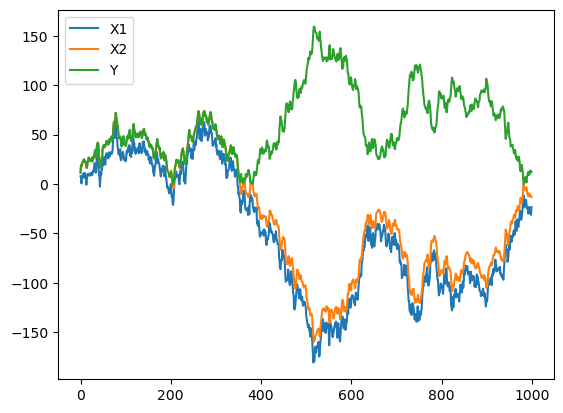

In [7]:
plt.plot(np.arange(nb_points), X1, label="X1")
plt.plot(np.arange(nb_points), X2, label="X2")
plt.plot(np.arange(nb_points), Y, label="Y")

plt.legend()

### Discretization 

In [8]:
nb_classes = {
    "X1": 30, 
    "X2": 30, 
    "Y": 30
}

discretizer = DumbDiscretizer(my_data, nb_classes=nb_classes)
my_data_index = discretizer.df

In [9]:
my_data_index.head()

,X1,X2,Y
0,23,22,3
1,23,23,4
2,23,23,4
3,23,23,4
4,23,23,4


### PGMPY friendly dataframe

In [10]:
my_data_index_pgmpy = pgmpy_friendly_transformer(my_data_index, sliding_window=sliding_window)

In [11]:
my_data_index_pgmpy.head(25)

,"(X1, 0)","(X2, 0)","(Y, 0)","(X1, 1)","(X2, 1)","(Y, 1)"
0,23,22,3,23,23,4
1,23,23,4,23,23,4
2,23,23,4,23,23,4
3,23,23,4,23,23,4
4,23,23,4,24,23,5
5,24,23,5,24,23,5
6,24,23,5,24,24,5
7,24,24,5,24,24,5
8,24,24,5,23,23,5
9,23,23,5,24,23,5


### Model creation  

In [12]:
# build model 
dbn = DBN(
    [
        (("X1", 0), ("X2", 0)),
        (("X2", 0), ("Y", 0)),
        (('X1', 0), ("X2", 1)),
        (('X2', 0), ("X2", 1)),
        (("X1", 1), ("X2", 1)),
        (("X2", 1), ("Y", 1))
    ]
)

In [13]:
dbn.fit(my_data_index_pgmpy.iloc[:-5, :])

### Model validation

In [14]:
my_data.tail()

,X1,X2,Y
995,-24.324106,-10.224710,10.312002
996,-29.335061,-10.691023,11.738743
997,-29.624297,-12.778225,13.687399
998,-31.208076,-13.254389,12.858897
999,-23.352673,-12.908613,12.251047


7.567387020201199
61.529336594395446


Text(0, 0.5, 'Proba')

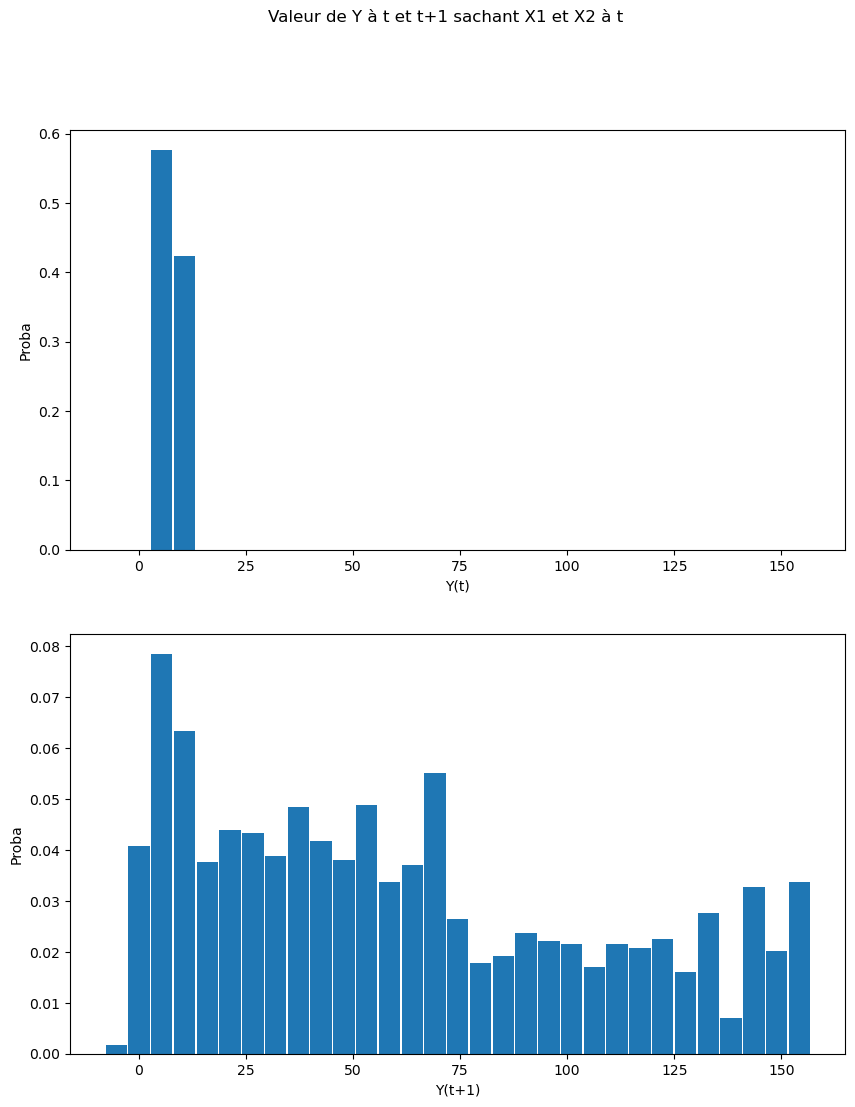

In [17]:
# framework pour l'inférence des DBN 
inference = DBNInference(dbn)

# known observation
evidence = {
    ('X1', 0): discretizer.indexer("X1", -29.62), 
    ('X2', 0): discretizer.indexer("X2", -12.78), 
}  # value must be indice 

# result of question given evidence what about variable
result = inference.forward_inference(variables=[('Y', 0), ("Y", 1)], 
                                     evidence=evidence)
proba_0 = result[("Y", 0)].values
proba_1 = result[("Y", 1)].values

# x-axis
x_ = [discretizer.reverse_indexer(column_name="Y", ind=i) for i in range(len(proba_0))]

print(np.dot(proba_0, x_))
print(np.dot(proba_1, x_))

fig, ax = plt.subplots(2, 1, figsize=(10, 12))

fig.suptitle("Valeur de Y à t et t+1 sachant X1 et X2 à t")

ax[0].bar(x_, proba_0, width=5.)
ax[0].set_xlabel("Y(t)")
ax[0].set_ylabel("Proba")

ax[1].bar(x_, proba_1, width=5.)
ax[1].set_xlabel("Y(t+1)")
ax[1].set_ylabel("Proba")